In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sns
import time

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline

import pickle# use to dump model 

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
dftrain = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/phishing_site_urls.csv')
dfeval = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/test.csv')

In [3]:
label_counts = pd.DataFrame(dftrain.Label.value_counts())
print(label_counts)

    Label
1  486263
0  392865


c:\users\steven\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

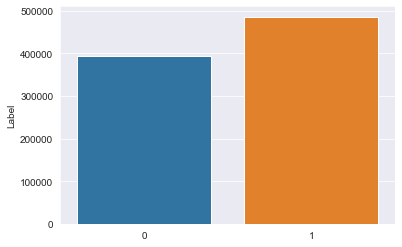

In [4]:
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

In [5]:
y_train = dftrain.pop('Label')
y_eval = dfeval.pop('Label')
urltrain = []
urleval = []

In [6]:
def treat_data(datain):
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    tokenizer.tokenize(datain.URL[0])
    print('Getting words tokenized ...')
    t0= time.perf_counter()
    datain['text_tokenized'] = datain.URL.map(lambda t: tokenizer.tokenize(t))
    t1 = time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    stemmer = SnowballStemmer("english")
    print('Getting words stemmed ...')
    t0= time.perf_counter()
    datain['text_stemmed'] = datain['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    print('Getting joiningwords ...')
    t0= time.perf_counter()
    datain['text_sent'] = datain['text_stemmed'].map(lambda l: ' '.join(l))
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    url = datain.pop('URL')
    dataout = datain.drop(columns=['text_tokenized', 'text_stemmed'])
    return dataout, url

In [7]:
dftrain, urltrain = treat_data(dftrain)
dftrain.sample(10)

Getting words tokenized ...
Time taken 2.5894803 sec
Getting words stemmed ...
Time taken 37.461330000000004 sec
Getting joiningwords ...
Time taken 0.2379300999999998 sec


,text_sent
410178,tsjonlin com stori php f
634915,hockeydraftcentr com html
421670,dksm ru
54048,legion virginia edu centurion
615728,bjyk exe
239128,klwnatr com
578713,bloodraventreasur com
774225,eventskofactivitymlbb cf
580110,songlyr com thrice for mile lyric
658477,mail eletehad net cp webhostbox net


In [8]:
dfeval, urleval = treat_data(dfeval)
dfeval.sample(10)

Getting words tokenized ...
Time taken 0.0008696999999955324 sec
Getting words stemmed ...
Time taken 0.006534999999999513 sec
Getting joiningwords ...
Time taken 0.0004637999999985709 sec


,text_sent
11,exploretal com taylormatheni
24,hao bat
47,easi french food com turnip recip html
15,stmichael sanmiguel com
22,lovejessi com whatsapp
122,elxosnfer web app
113,stuffaboutnam com perci index htm
7,www agdeal com leo
16,amazon com tango danc stori simon collier dp
83,a hentaiwonderland com


In [9]:
CATEGORICAL_COLUMNS = ['text_sent']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

In [10]:
def make_input_fn(data_df, label_df, num_epochs=15, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [11]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Steven\\AppData\\Local\\Temp\\tmptaw3ne05', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
linear_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


c:\users\steven\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Steven\AppData\Local\Temp\tmptaw3ne05\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 167.085
INFO:tensorflow:loss = 0.67333764, step = 100 (0.599 sec)
INFO:tensorflow:global_step/sec: 317.699
INFO:tensorflow:loss = 0.68545437, step = 200 (0.315 sec)
INFO:tensorflow:global_step/sec: 330.304
INFO:tensorflow:loss = 0.6996943, step = 300 (0.303 sec)
INFO:tensorflow:global_step/sec: 348.75
INFO:tensorflow:loss = 0.68240285, step = 400 

In [ ]:
result = linear_est.evaluate(eval_input_fn)
print(result)
print(result['accuracy'])